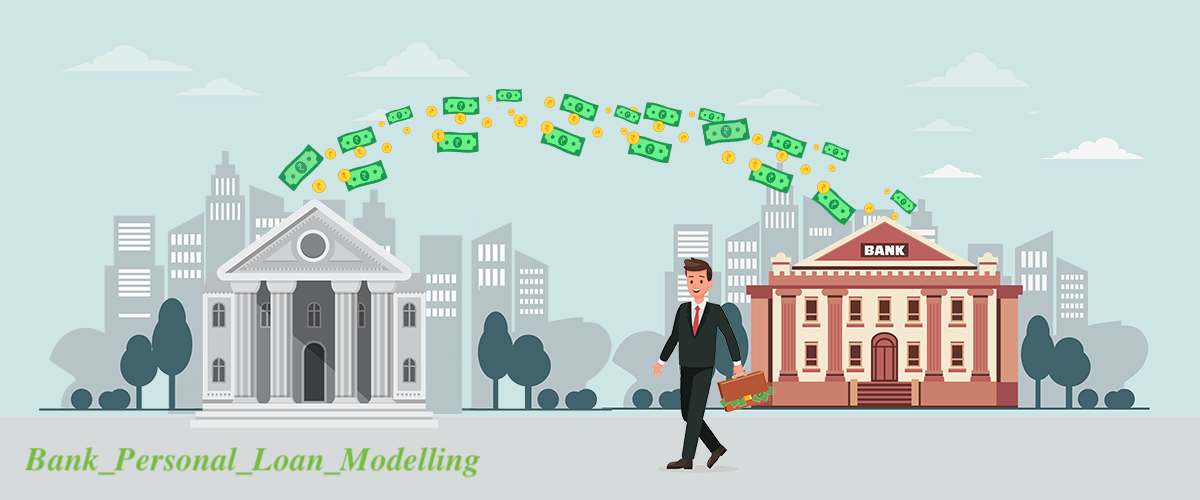

__In this notebook, we are going to use some algorithms ( KNN, Logistic Regression, Naive Bayes, Decision Tree ) to build a model to predict whether a person accepts the bank loan offer or not in order to some features__

### Let's get started:

# Step 1 : Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from feature_engine.discretisation import EqualWidthDiscretiser

__Setting the background-color of axes & fontsize/labelsize :__

In [2]:
sns.set_style("dark")
plt.rcParams.update({"font.size" : 12, "axes.labelsize" : 14})

# Step 2 : Import Dataset

In [3]:
df = pd.read_csv("Loan_data.csv")

# Step 3 : Dataset Overview

In [4]:
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1


__The << Personal Loan >> is the dependant variable and the others are considered as independant variables.__<br>
__It is a classification problem beacause of the dependant variable is discrete__

In [5]:
df.shape

(5000, 14)

__The dataset has 5000 rows and 14 columns__

## Step 3.1 : Dataset Basic information :

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


__*CCAvg should be a type of float by transforming the data__

## Step 3.2 : Numerical Columns Description:

In [7]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.5000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.3384,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.1046,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.7742,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.5030,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.3964,1.147663,1.0,1.00,2.0,3.00,4.0
Education,5000.0,1.8810,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.4988,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.0960,0.294621,0.0,0.00,0.0,0.00,1.0
Securities Account,5000.0,0.1044,0.305809,0.0,0.00,0.0,0.00,1.0


+ __About the Experience feature, it cannot be smaller than zero, because experiences <br> are counted at 0 means
that no experience, so we should pay attention to it later__
+ __ZIP Codes are 5 digits but here it starts with 4 digit number 9307 which is noise, check it later__

## Step 3.3 : Object Columns Description :

In [8]:
df.describe(include = "object")

,CCAvg
count,5000
unique,108
top,0/30
freq,241


In [9]:
def set_freq_label(ax, fmt = "%.2f", padding = 3):
    for cont in ax.containers:
        ax.bar_label(cont, padding = padding, fmt = fmt)

In [10]:
def plot_unique_freq(df):
    ax = df.nunique().sort_values().plot.bar(figsize = (16,7), color = "royalblue")
    set_freq_label(ax, fmt = "%1.f", padding = 5)
    plt.xlabel("Columns")
    plt.ylabel("Frequency")
    plt.margins((0.1))
    plt.title("Column Unique Value Counts", size = 20, y = 1.08, fontweight = "bold")
    plt.grid()
    plt.show()

## Step 3.4 : Seperate Categorical & Continuous  Features

__Plotting the number of feature unique values :__

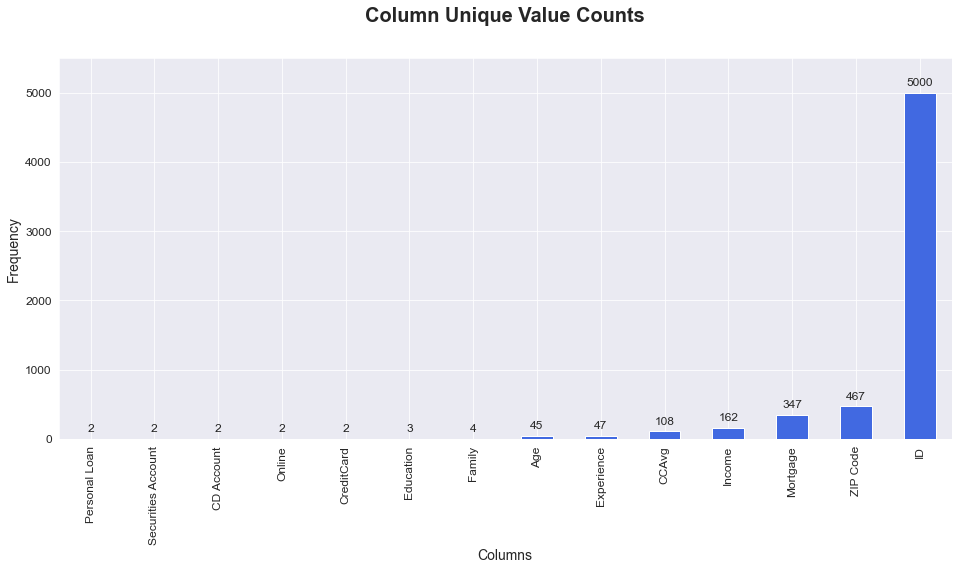

In [11]:
plot_unique_freq(df)

+ __The ID column looks like an identifier, it should be removed__
+ __As i explained above about the CCAvg which must be converted to float type, it is in wrong type, <br>
 below, i'll consider it as a continous feature__
+ __From Personal Loan ( Target ) to Family  look like categorical because of their number of unique values which are very small__
+ __The ZIP Code feature is nominal categorical, but its unique values are almost high__

### Step 3.4.1 : Categorical Variables 

In [12]:
categorical_vars = df[[ "Personal Loan", "Securities Account", "CD Account", "Online", 
                "CreditCard","Education","Family", "ZIP Code"]].columns

__Printing the categorical features value counts :__

In [13]:
for var in categorical_vars:
    print(df[var].sort_values().value_counts(), "-" * 20, sep = "\n")

0    4520
1     480
Name: Personal Loan, dtype: int64
--------------------
0    4478
1     522
Name: Securities Account, dtype: int64
--------------------
0    4698
1     302
Name: CD Account, dtype: int64
--------------------
1    2984
0    2016
Name: Online, dtype: int64
--------------------
0    3530
1    1470
Name: CreditCard, dtype: int64
--------------------
1    2096
3    1501
2    1403
Name: Education, dtype: int64
--------------------
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
--------------------
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
94087      1
90813      1
94404      1
90068      1
9307       1
Name: ZIP Code, Length: 467, dtype: int64
--------------------


__There is a noise in ZIP Code !__

###  Step 3.4.2 : Numerical & Quantitative  Variables

In [14]:
cont_vars = df.drop(categorical_vars, axis = 1).columns

# Step 4 : Data Prepration

##   Step 4.1 : Feature Subset Selection

__The number of ID unique values ) :__

In [15]:
df.ID.nunique()

5000

__ID description :__

In [16]:
df.ID.describe()

count    5000.000000
mean     2500.500000
std      1443.520003
min         1.000000
25%      1250.750000
50%      2500.500000
75%      3750.250000
max      5000.000000
Name: ID, dtype: float64

__The ID act as an identifier, Although the dataset has default identifier,<br> so it should be removed__

In [17]:
df.drop("ID", axis = 1, inplace = True)

__Modifying the numerical variables list__

In [18]:
cont_vars = cont_vars.drop("ID")

## Step 4.2 : Feature Transformation

### Step 4.2.1 : CCAvg

__The CCAvg is the average of buying cost, therefore it should be float type number <br>
but the CCAvg values are in an incorrect foramt like 2/3 we want 2.3__

In [19]:
df.CCAvg

0       1/60
1       1/50
2       1/00
3       2/70
4       1/00
        ... 
4995    1/90
4996    0/40
4997    0/30
4998    0/50
4999    0/80
Name: CCAvg, Length: 5000, dtype: object

__Transforming :__

In [20]:
df1 = df.copy()
df1.CCAvg = df.CCAvg.str.replace("/",".").astype(float)

__CCAvg description :__

In [21]:
df1.CCAvg.describe()

count    5000.000000
mean        1.937938
std         1.747659
min         0.000000
25%         0.700000
50%         1.500000
75%         2.500000
max        10.000000
Name: CCAvg, dtype: float64

## Step 4.2 : Feature Selection

__Correlation is one of the feature selection statistical method__

__Correlation table of the continuous features :__

In [22]:
df_corr = df1[cont_vars].corr()
df_corr.style.background_gradient(cmap='summer')

,Age,Experience,Income,CCAvg,Mortgage
Age,1.000000,0.994215,-0.055269,-0.052012,-0.012539
Experience,0.994215,1.000000,-0.046574,-0.050077,-0.010582
Income,-0.055269,-0.046574,1.000000,0.645984,0.206806
CCAvg,-0.052012,-0.050077,0.645984,1.000000,0.109905
Mortgage,-0.012539,-0.010582,0.206806,0.109905,1.000000


+  __Age & Experience has 99% correlation with each other, it can be seen multicollinearity relationship__
+ __High correlation between two features can afect badly on the model__
+ __If two features are correlated, the model only really needs one of them,<br> as the second one does not add additional information. We will use <br> the Pearson Correlation here__
    

__We have to remove either Age or Experience to solve multicollinearity problem<br>
As Experience has some noise data where its values are negative while Age does not <br> have any outlier or noise, so Experience will be the best choice for removal__

__Removing Experience :__

In [23]:
df1.drop("Experience", axis = 1, inplace = True)

__Updating the list of continuous features :__

In [24]:
cont_vars = cont_vars.drop("Experience")

## Step 4.3 : Outlier Detection 

### Step 4.3.1 : Continuous Feature Range

__Plotting continous variables with the combination of boxplot and stripplot to better analyzing__

In [25]:
cont_vars

Index(['Age', 'Income', 'CCAvg', 'Mortgage'], dtype='object')

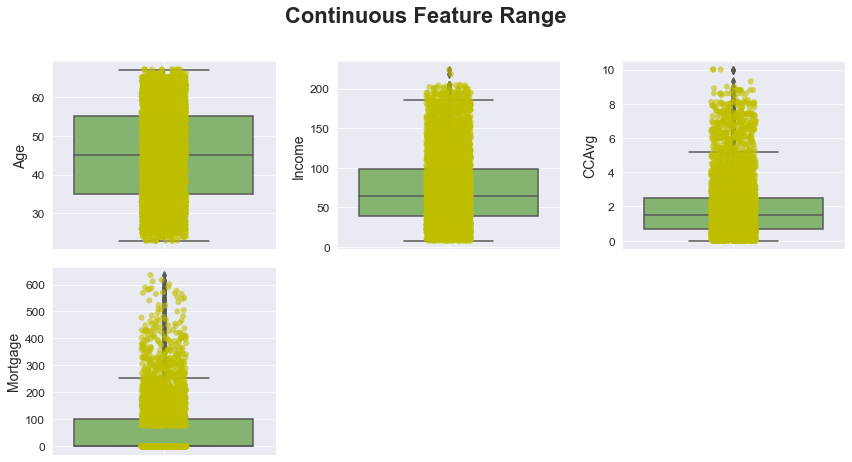

In [26]:
plt.figure(figsize = (12,12))
for idx, col in enumerate(cont_vars):
    plt.subplot(4,3, idx + 1)
    sns.boxplot(y = col, data = df1, palette = "summer")
    sns.stripplot(y = col, data = df1, color = "y", alpha = 0.6, size = 6)
    plt.grid()
plt.suptitle("Continuous Feature Range", size = 22, fontweight = "bold", y = 1.01)
plt.tight_layout()
plt.show()

__Outliers look like validate__

In [27]:
def outlier_detection(df1,cont_vars):
    ''' determining the outlier indexes and 
    outlier percentage compared to the total '''
    outlier_info = []
    outlier_index = []
    for col in list(cont_vars):
        Q1 = df1[col].quantile(.25)
        Q3 = df1[col].quantile(.75)
        IQR = Q3 - Q1
        minimum = Q1 - (1.5 * IQR)
        maximum = Q3 + (1.5 * IQR)
        df = df1[(df1[col] > maximum) | (df1[col] < minimum)]
        outlier_info.append({"Features" : col ,"outlier_%" : np.ceil(((df.shape[0] / df1.shape[0]) * 100)),"outlier_idx" : list(df.index)})
        outlier_index.extend(df.index)
    return outlier_info, outlier_index

In [28]:
outlier_info, outlier_index = outlier_detection(df1,cont_vars)

In [29]:
outlier_info = pd.DataFrame(outlier_info)
outlier_index = pd.Series(outlier_index)

__Outlier Information :__

In [30]:
outlier_info

,Features,outlier_%,outlier_idx
0,Age,0.0,[]
1,Income,2.0,"[18, 47, 53, 59, 303, 329, 459, 526, 677, 740,..."
2,CCAvg,7.0,"[9, 18, 44, 55, 61, 90, 131, 145, 150, 151, 16..."
3,Mortgage,6.0,"[22, 39, 42, 59, 66, 112, 119, 130, 187, 209, ..."


### Step 4.3.2 : Outlier Percentage Compared To The Total

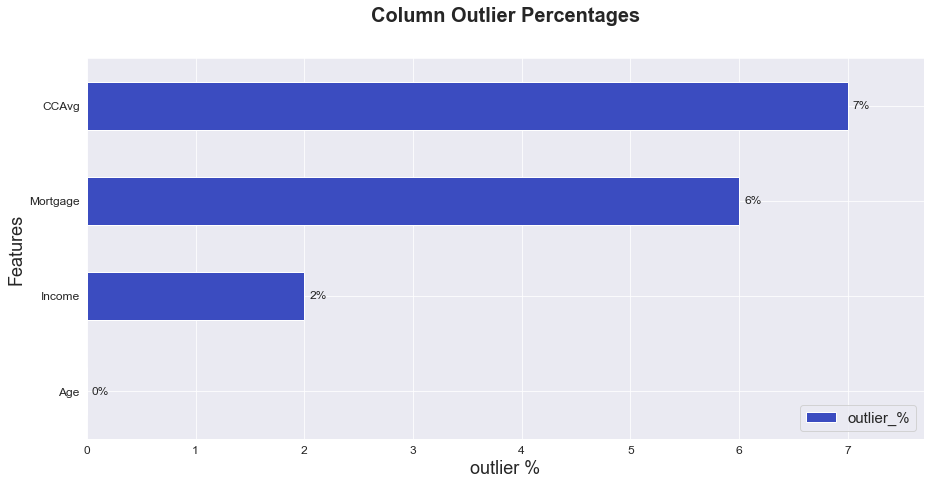

In [31]:
ax = outlier_info.sort_values("outlier_%").plot.barh(x = "Features", y = "outlier_%",figsize = (15,7), cmap = "coolwarm")
set_freq_label(ax,fmt = "%1.f%%", padding = 5)
plt.ylabel("Features", size = 18)
plt.xlabel("outlier %", size = 18)
plt.margins((0.1))
plt.legend(loc = 4,fontsize = 15)
plt.title("Column Outlier Percentages", size = 20, y = 1.08, fontweight = "bold")
plt.grid()
plt.show()

### Step 4.3.3 : Density Disturbution Of Outlier Indexes

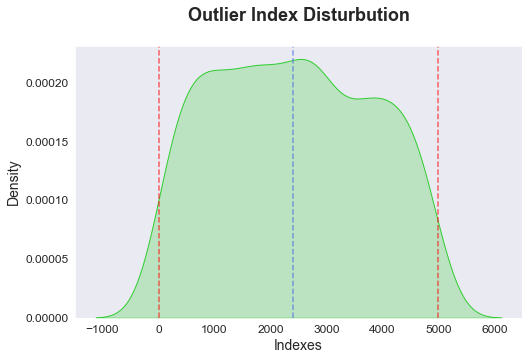

In [32]:
plt.figure(figsize = (8,5))
sns.kdeplot(x = outlier_index, fill = True, color = "limegreen")
plt.axvline(x = outlier_index.mean(), ls = "--", color = "royalblue", alpha = 0.6)
plt.axvline(x = outlier_index.min(), ls = "--", color = "r", alpha = 0.6)
plt.axvline(x = outlier_index.max(), ls = "--", color = "r", alpha = 0.6)
plt.title("Outlier Index Disturbution", size = 18, fontweight = "bold", y = 1.07)
plt.xlabel("Indexes")
plt.show()

+ __Outlier indexes have an normal disturbution on the continuous features__

__Outlier index shape :__

In [33]:
outlier_index = np.array(outlier_index)
outlier_index.shape

(711,)

### Step 4.3.4 : ZIP Code

__The significant outlier in ZIP Code may affect badly on model, because it is so far from the main disturbution__

__Plotting ZIP Code with boxplot :__

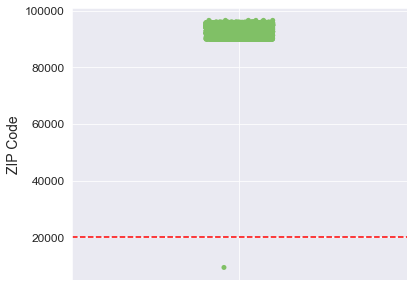

In [34]:
plt.figure(figsize = (6,5))
sns.stripplot(y = "ZIP Code", data = df1, palette = "summer")
plt.axhline(y = 20000, ls = "--", color = "r")
plt.grid()
plt.show()

__The significant outliers in ZIP Code :__

In [35]:
df[df["ZIP Code"] < 20000]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,51,25,21,9307,4,0/60,3,0,0,0,0,1,1


__The outlier in ZIP Code is ( 9307 ), in fact, zip codes have 5 digits, but <br> here the wrong data is 9307 which has 4 digits and the others have 5 digits<br>
It is obvious that the data is noise__

In [36]:
ZIPCode_outlier_indexes = df[df["ZIP Code"] < 20000].index

In [37]:
ZIPCode_outlier_indexes

Int64Index([384], dtype='int64')

__the outlier ( noise ) index = 384__

## Step 4.4: Discover Missing Values¶

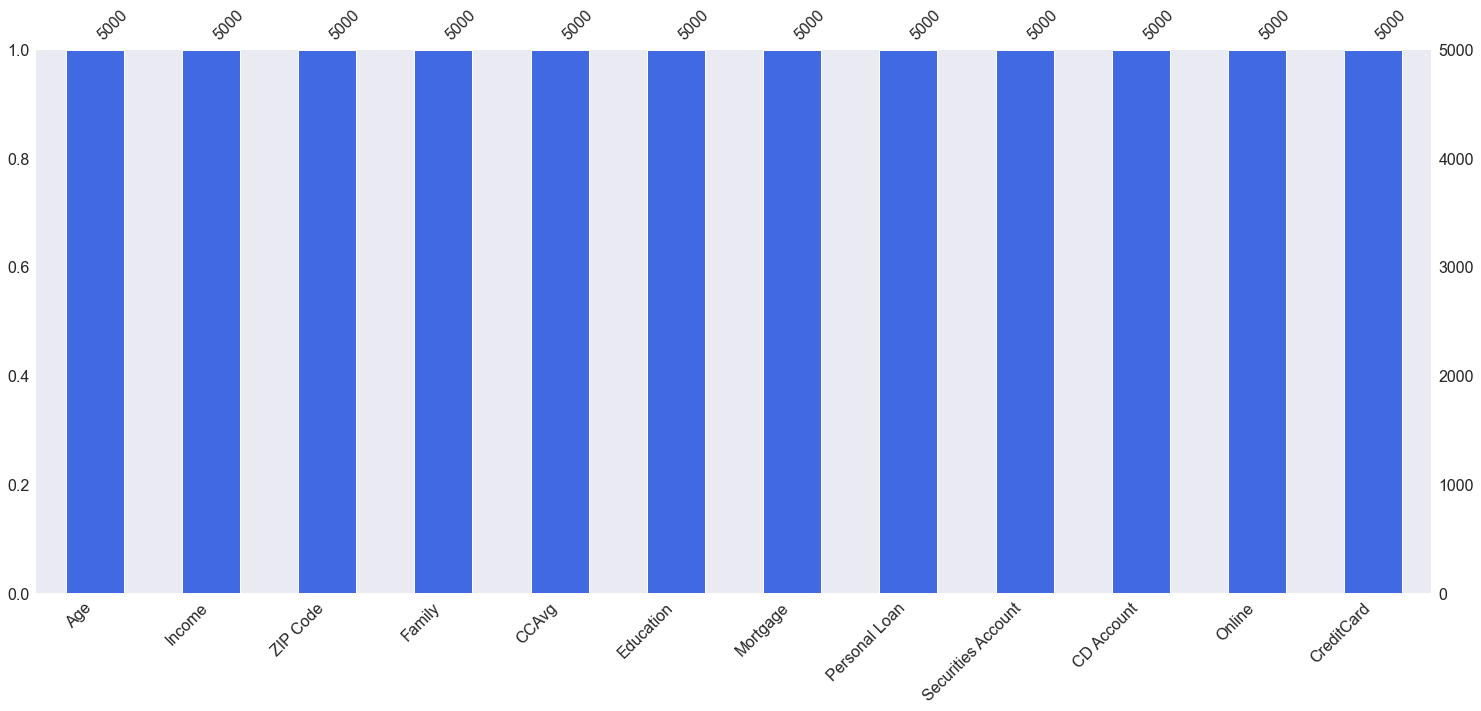

In [38]:
msno.bar(df1, color = "royalblue")
plt.show()

<strong> There is no missing value in this dataset </strong>

## Step 4.5: Discover Duplicates¶

In [39]:
df1.duplicated().sum()

0

<strong> There is no duplicated rows in this dataset </strong>

## Step 4.6 : Outlier Data Operations

__ZIP Code noise data index :__

In [40]:
ZIPCode_outlier_indexes

Int64Index([384], dtype='int64')

__ZIP Code noise data :__

In [41]:
df1.iloc[ZIPCode_outlier_indexes[0]]

Age                     51.0
Income                  21.0
ZIP Code              9307.0
Family                   4.0
CCAvg                    0.6
Education                3.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   1.0
CreditCard               1.0
Name: 384, dtype: float64

__Dropping the noise :__

In [42]:
df2 = df1.copy()
df2 = df2.drop(ZIPCode_outlier_indexes[0]).reset_index(drop = True)

# Step 5 : EDA

## Step 5.1 : Target Vs Continuous Features Bivariate/Univariate Analysis

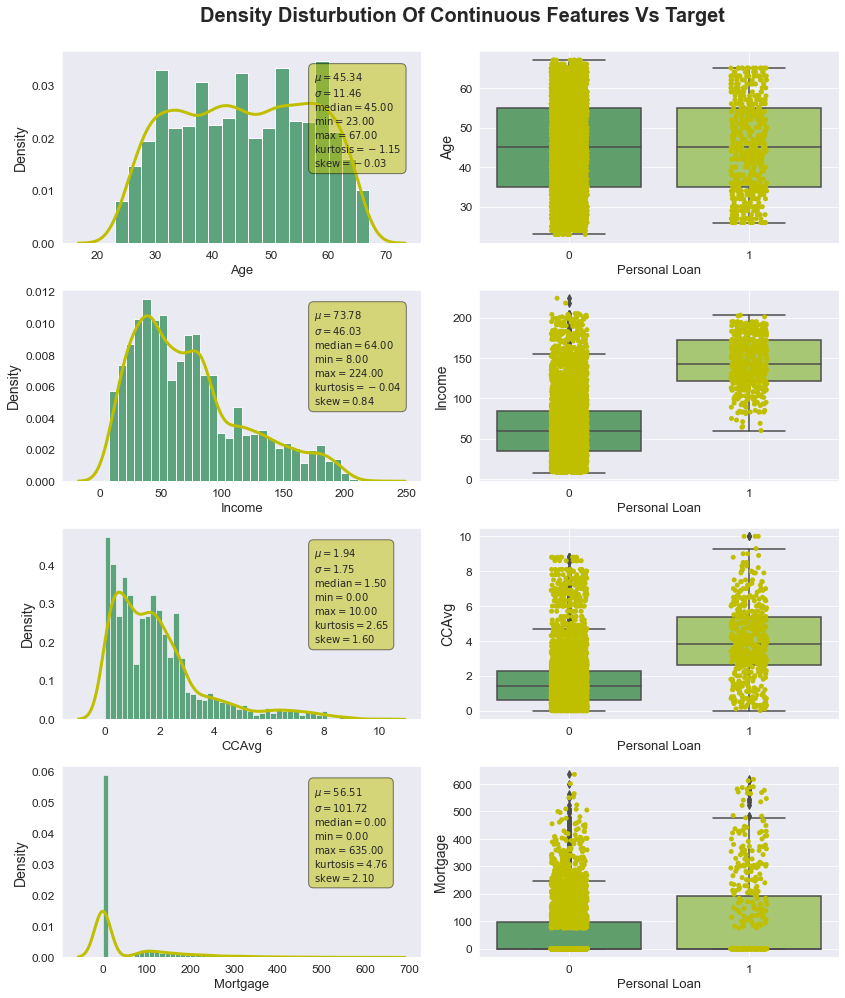

In [43]:
plt.figure(figsize = (12,20))
i = 0
for idx, col in enumerate(cont_vars):
    i += 1 ;
    plt.subplot(6,2, idx + i,)
    ax = sns.histplot(x = col, data = df2, color = "seagreen", stat = "density")
    sns.kdeplot(x = col, data = df2, color = "y", linewidth = 3)
    plt.xlabel(col, size = 13)
    
    # set text on axes
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df2[col].mean(),
    r'$\sigma=%.2f$' %df2[col].std(),
    r'$\mathrm{median}=%0.2f$' %np.median(df2[col]),
    r'$\mathrm{min}=%.2f$' %df2[col].min(),
    r'$\mathrm{max}=%.2f$' %df2[col].max(),
    r'$\mathrm{kurtosis}=%.2f$' %df2[col].kurtosis(),
    r'$\mathrm{skew}=%.2f$' %df2[col].skew(),
    ))
    ax.text(0.7, 0.90, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='y', edgecolor='black', pad=0.5, alpha = 0.5))
    
    plt.subplot(6,2, idx + (i + 1))
    sns.boxplot(x = "Personal Loan", y = col, data = df2, palette = "summer")
    sns.stripplot(x = "Personal Loan", y = col, data = df2, color = "y")
    plt.xlabel("Personal Loan", size = 13)
    plt.grid()

plt.suptitle("Density Disturbution Of Continuous Features Vs Target", y = 1, x = 0.55, size = 20,
    fontweight = "bold")
plt.tight_layout()
plt.show()

+ __Conculsion :__
  - __As shown above that Income and CCAvg and Mortgage has higher correlation with  the target ( Personal Loan )<br> than others,   because the boxplots in these two features show that when we switch on each class the median/mean are <br>
  highly changed specially Income, but when  another features on the target classes are switched , their median/mean is not  <br> changed and they are approximately in the same median/mean which means low correlation with the target ( Personal Loan )__
  - __Results :__
   * __More income more accepeted offers__
   * __More CCAvg more accepeted offers__
   * __More Mortgage more accepeted offers__
  

## Step 5.2 : Continuous Features Vs Continuous Features 

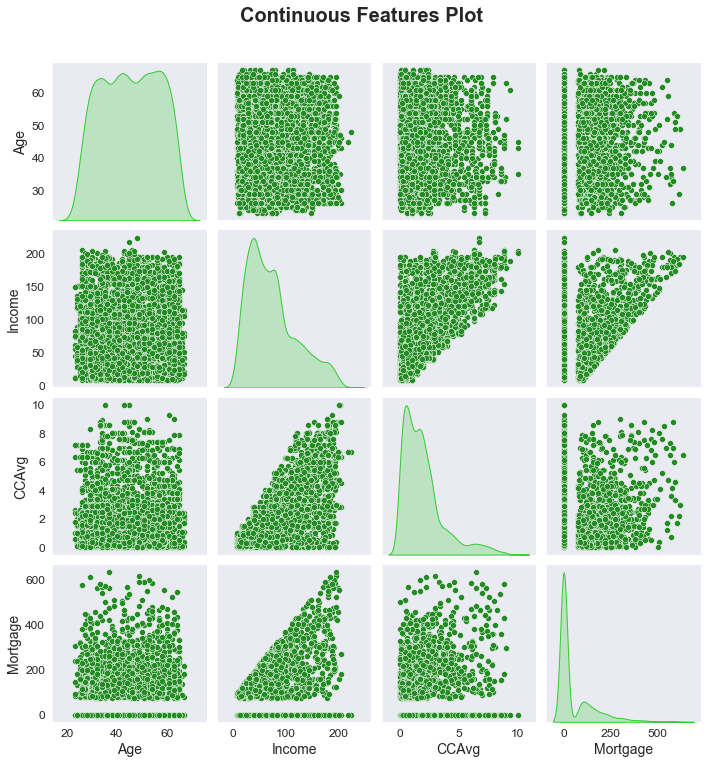

In [44]:
sns.pairplot(df2, vars = df2.loc[:, cont_vars], plot_kws = {'color' : "forestgreen"},
            diag_kind = "kde", diag_kws = {"color" : "limegreen"})
plt.suptitle("Continuous Features Plot", y = 1.06,x = 0.51,  size = 20, fontweight = "bold")
plt.show()

+ __Conculsion :__
   - __Income with CCAvg has a high correlation in such a way : more Income more CCAvg ( vice versa )__
   - __Income with Mortgage almost has a high correlation in such a way : more Income more Mortgage ( vice versa )__
   - __CCAvg with Mortgage almost has a high correlation in such a way : more CCAvg more Mortgage ( vice versa )__
   - __Other features almost have zero correlation with each other__


## Step 5.3 : Target Vs Categorical Features Bivariate/Univariate Analysis

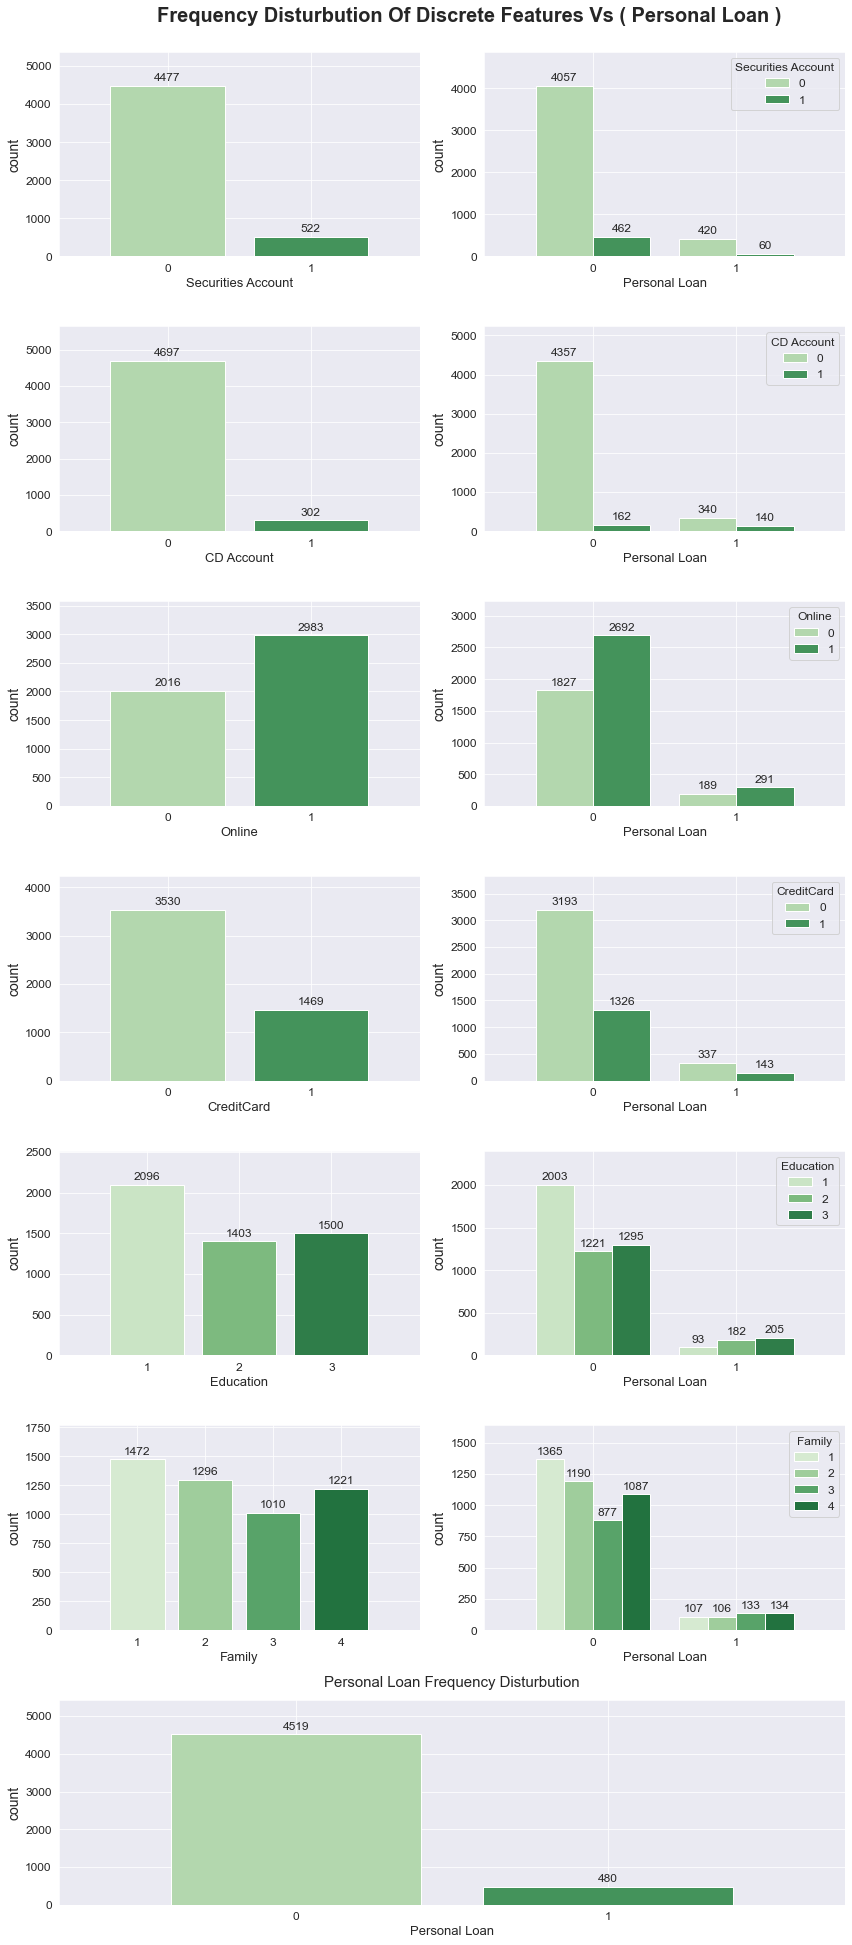

In [45]:
plt.figure(figsize = (12,27))
i = 0
for idx, col in enumerate(categorical_vars.drop(["Personal Loan", "ZIP Code"])):
    i += 1
    plt.subplot(7,2, idx + i)
    ax = sns.countplot(x = col, data = df2, palette = "Greens")
    plt.xlabel(col, size = 13)
    set_freq_label(ax, "%1.f")
    plt.margins(0.2)
    plt.grid()
    plt.subplot(7,2, idx + (i + 1))
    ax = sns.countplot(x = "Personal Loan", data = df2, hue = col, palette = "Greens")
    plt.xlabel("Personal Loan", size = 13)
    set_freq_label(ax, "%1.f")
    plt.margins(0.2)
    plt.grid()
    
plt.subplot(7,1, 7)
ax = sns.countplot(x = "Personal Loan", data = df2, palette = "Greens")
plt.xlabel("Personal Loan", size = 13)
set_freq_label(ax,"%1.f")
plt.margins(0.2)
plt.title("Personal Loan Frequency Disturbution", size = 15, pad = 13)
plt.grid()
    
plt.suptitle("Frequency Disturbution Of Discrete Features Vs ( Personal Loan )", y = 1, x = 0.55, size = 20,
            fontweight = "bold")
plt.tight_layout()
plt.show()

__ZIP Code Bivariate/Univariate Analysis :__

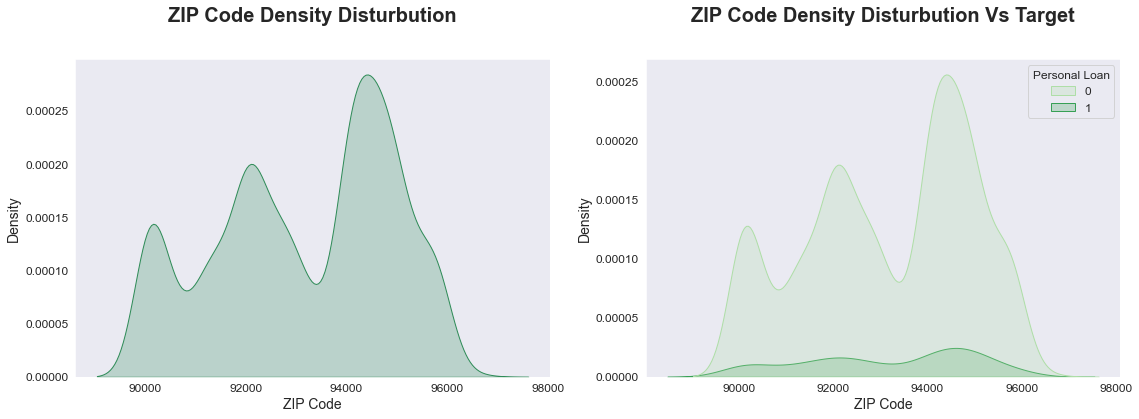

In [46]:
plt.figure(figsize = (16,6))
plt.subplot(121)
sns.kdeplot(x = "ZIP Code", data = df2, color = "seagreen", fill = True)
plt.title("ZIP Code Density Disturbution", size = 20, fontweight = "bold", y = 1.1)
plt.subplot(122)
sns.kdeplot(x = "ZIP Code", data = df2, hue = "Personal Loan", palette = "Greens", fill = True)
plt.title("ZIP Code Density Disturbution Vs Target", size = 20, fontweight = "bold", y = 1.1)
plt.tight_layout()
plt.show()

+ __Conculsion :__

    - __In the first step, it can be seen imbalanced data in some categorical varibales <br> 
    like : <strong> Personal Loan ( target ) </strong>, Credit Card, CD Account, Securities Account.__
    - __Point : Imbalanced data occurs when there is a high distance between category frequency in each variable__
    -  __As a result of there are some imbalanced data we cannot clearly identify how the features can affect on  <br>
    the target classes, but if look closer we realize that 
    CD Account and  Education and Family play an important role <br>in target estimation because the frequency of their categories has changed a lot with the change of the target class. <br> 
    when switching to class 1 in Education and Family, the order of bars is reversed which shows a high correlation__
       * __it says that if a person has <b> CD Account </b> , there is more chance to accept loan offer than without CD Account__
     * __if a person has more valuable degree of <b> Education </b>, there is more chance to accept the loan offer__
     * __if a person has more <b> Family </b> member , there is more chance to accept the loan offer__

    - __As a result of ZIP Code has High number of unique values and
    Continuous <br> disturbution, while it is categorical, so
    i use kdeplot to analyze this feature<br> 
    ZIP Code analysis :__
     * __When switching via the classes of the target ( Personal loan ) , there is no change in its range <br>
     which means that it does not really affect on the target__
    
  



# Step 6 :  Correlation Analysis

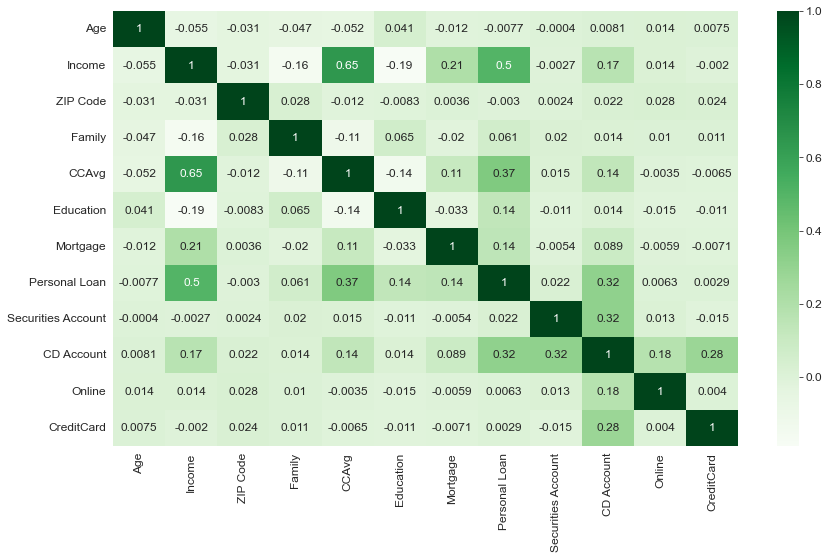

In [47]:
df2_corr = df2.corr()
plt.figure(figsize = (14, 8))
sns.heatmap(df2_corr,annot = True, cmap = plt.cm.Greens)
plt.show()

+ __Conculsion :__
  - __The method corr() assumes that there is a linear relationship between variables, therefore we cannot <br>
    clearly underestand the real correlation score for some features, because  some of the features <br> might have non-linear relationship which breaks the corr assumptions, but for those have <br>linear relationship with each other, the score is correctly shown__
 - __This plot applies to some of the ( above analysis )__
    - __As previous analyzes, there is a high correlation between CCAvg and Income which that is the most <br> important feature in this dataset__

# Step 7 : Model Building 

## Step 7.1 : Self-made Functions For Model Evaluation

In [48]:
def evaluate_models(models, X_train, X_test, y_train, y_test, NB_X_train, NB_X_test, text_result = True):
    compare_clf = []
    for clfName, clf in models :
        exist_nb = ("nb" in clfName)
        if exist_nb:
            y_pred = clf.predict(NB_X_test)
            y_pred_proba = clf.predict_proba(NB_X_test)
        else:
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
        
        if text_result:
            print(clfName ,classification_report(y_test, y_pred),"confusion matrix", confusion_matrix(y_test, y_pred),
                  "-" * 20, Counter(y_pred), "-"*60, sep = "\n")
        
        compare_clf.append((pd.Series({"Precision" : precision_score(y_test, y_pred, average = "macro"),
                           "Recall" : recall_score(y_test, y_pred, average = "macro"),
                           "F1" : f1_score(y_test, y_pred, average = "macro"),
                           "Accuracy" : accuracy_score(y_test, y_pred),
                           "AUC (positive label : 1)" : roc_auc_score(y_test, y_pred_proba[:, 1]),
                           "Train_Score" : clf.score((X_train if not exist_nb else NB_X_train),y_train),
                           "Test_Score" : clf.score((X_test if not exist_nb else NB_X_test), y_test),
                           "Counter" : Counter(y_pred)}, name = clfName)))
    compare_clf = pd.DataFrame(compare_clf).T
    return compare_clf

In [49]:
def evaluate_model(model_name, y_test, y_pred_test, y_train, y_pred_train) :
    print(model_name.center(55, "*"))
    print("Test result :" ,classification_report(y_test, y_pred_test),"Confusion matrix", confusion_matrix(y_test, y_pred_test),
              "-" * 20, Counter(y_pred_test), "-"*55, sep = "\n")
    print("Train result :" ,classification_report(y_train, y_pred_train),"Confusion matrix", confusion_matrix(y_train, y_pred_train),
              "-" * 20, Counter(y_pred_train), "-"*55, sep = "\n")

In [50]:
def plot_confusion_matrix_legend(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm[0,0],cm[0,1],cm[1,0],cm[1,1]
    fig, ax = plt.subplots(figsize = (6, 6))

    textstr = '\n'.join((
        "The amount of Correct Predictions = {}".format(cm[0,0] + cm[1,1]),
        "The amount of Incorrect Predictions = {}".format(cm[0,1] + cm[1,0]),
        "-"*30,
        "Accuracy = {:.2f}".format((cm[0,0] + cm[1,1]) / (cm.sum())),
        "Classification Error = {:.2f}".format((cm[0,1] + cm[1,0]) / (cm.sum()))
    ))
    ax.text(1.06, 0.98, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='y', edgecolor='white', pad=0.4, alpha = 0.8), 
            color = "white")
    cm = confusion_matrix(y_test, y_pred)
    group_names = ["TP","FP","FN","TN"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    labels = [f"{v1} ({v2})" for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt="", cmap = plt.cm.cividis_r, cbar = False)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    plt.rcParams.update({"font.size" : 12, "axes.labelsize" : 14})
    plt.show()

__Naive bayes technique against this type of dataset which has both categorical and continuous features :__

In [51]:
def get_ready_data_for_nb(df, cont_vars, test_size = .25):
    discretizer = EqualWidthDiscretiser(bins = 3, variables = list(cont_vars))
    df_transformed = discretizer.fit_transform(df)
    X,y = df_transformed.drop("Personal Loan", axis = 1), df_transformed["Personal Loan"]
    X_train_trs, X_test_trs, y_train_trs, y_test_trs = train_test_split(X,y,
                                                                        test_size = test_size, random_state = 0)
    return X_train_trs, X_test_trs

## Step 7.2 : Model Building In The First Layer 

###  Starting With 3 Popular Algorithms : ( Logistic Regreesion, Naive Bayes, KNN ) :

__Data preparation :__

In [52]:
X, y = df2.drop("Personal Loan", axis = 1), df2["Personal Loan"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

__Train and Test shape :__

In [53]:
print("Train And Test Shapes".center(40, "*"), end = "\n"*2)
print("X_train : ",X_train.shape,
     "\nX_test :", X_test.shape,
     "\ny_train : ", y_train.shape,
     "\ny_test : ", y_test.shape,)
print("","*" * 40, sep = "\n")

*********Train And Test Shapes**********

X_train :  (3749, 11) 
X_test : (1250, 11) 
y_train :  (3749,) 
y_test :  (1250,)

****************************************


__Model building :__

In [54]:
knn_model =  KNeighborsClassifier()
logreg_model = LogisticRegression(max_iter = 500)
# fitting model(KNN, Logistic Regression) on training data 
knn_model.fit(X_train, y_train)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [55]:
# the x_train and x_test of this method is different with others 
NB_X_train, NB_X_test = get_ready_data_for_nb(df2, cont_vars)
nb_model = ComplementNB()
nb_model.fit(NB_X_train, y_train)

ComplementNB()

+ __We all know that the dataset is imbalanced__
+ __Naive Bayes :__
    + __Because of the dataset has both categorical and continuous features, a problem comes into naive bayes classifier <br> because of the assumption in naive bayes which emphasizes that features must be either just categorical or just continuous, <br> so we use the technique which is shown and explained in get_ready_data_for_nb() self_made function in the step 7.1__
    + __I use ComplementNB instead of Categorical/MultinomialNB because the ComplementNB is more robust to imbalanced data <br> than the other methods__

__Model evaluation :__

In [56]:
models1 = [("knn1",knn_model), ("logreg1",logreg_model),("nb1",nb_model)]
compare_clf1 = evaluate_models(models1, X_train, X_test, y_train, 
                                                  y_test, NB_X_train, NB_X_test)

knn1
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1126
           1       0.53      0.22      0.31       124

    accuracy                           0.90      1250
   macro avg       0.72      0.60      0.63      1250
weighted avg       0.88      0.90      0.88      1250

confusion matrix
[[1102   24]
 [  97   27]]
--------------------
Counter({0: 1199, 1: 51})
------------------------------------------------------------
logreg1
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1126
           1       0.57      0.31      0.40       124

    accuracy                           0.91      1250
   macro avg       0.75      0.64      0.68      1250
weighted avg       0.89      0.91      0.90      1250

confusion matrix
[[1096   30]
 [  85   39]]
--------------------
Counter({0: 1181, 1: 69})
------------------------------------------------------------
nb1
              precision  

- __In this step, no assumptions, scaling, optimizing, etc... are used__
- __The algorithms do not work well on class 1, the reason is that the dataset is imbalanced and <br>
generally these three algorithms have poor performance on imbalanced data__
- __Counter shows the amount of the predicted classes on 0,1__
- __According to above metrics, we can say Logistic Regression works better than others till now__

__Imbalanced Description :__
   - __In terms of imbalanced data, you get a pretty high accuracy just by predicting the majority class,<br>but you fail to capture the minority class, so better to check the precison/recall/f1 by macro average<br> in imbalanced data instead checking just the accuracy because the accuracy is not trustable in this type of data__
   - __Cheking metrics like precision/recall/f1 by average (macro) is because of the average : macro gives better <br> and more trustable score on imbalanced data__
   - __I may later check the models just by f1 score average macro because f1 is calculated by precision and recall__

__Evaluation metrics by macro average and others like (AUC, Train/Test score) :__

In [57]:
compare_clf1

,knn1,logreg1,nb1
Precision,0.724256,0.746622,0.679437
Recall,0.598214,0.643937,0.831734
F1,0.628264,0.677148,0.716005
Accuracy,0.9032,0.908,0.852
AUC (positive label : 1),0.793485,0.925951,0.919656
Train_Score,0.92398,0.907975,0.829021
Test_Score,0.9032,0.908,0.852
Counter,"{0: 1199, 1: 51}","{0: 1181, 1: 69}","{0: 989, 1: 261}"


__Train/Test scores show nothing about overfitting or underfitting__

## Step 7.3 : Model Building In The Second Layer 

__In the first step of model building, i did not consider the assumtions like :__
   - __scaling data__
   - __Imbalanced data handling__

__Totally, this dataset is not totally suitable for Naive Bayes, because the features dont have equal contribution <br>
  to the target and some features have correlations with each other, ... <br>
  But i still want to use it for comparing__ 

__Disturbution of Personal Loan ( target ) :__

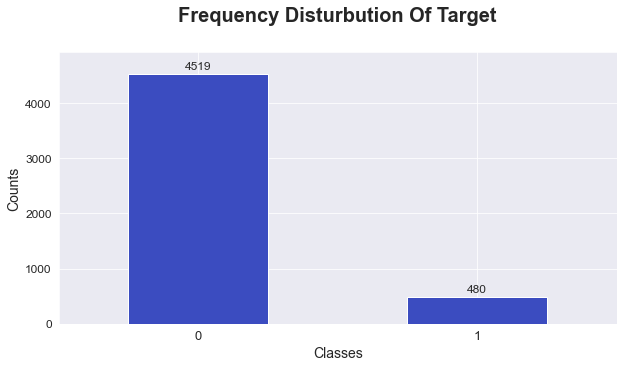

In [58]:
ax = y.value_counts().plot.bar(figsize = (10, 5), cmap = plt.cm.coolwarm)
set_freq_label(ax, "%1.f")
plt.margins((0.09))
plt.xticks(rotation = 0, size = 13)
plt.ylabel("Counts")
plt.xlabel("Classes")
plt.title("Frequency Disturbution Of Target", size = 20, y = 1.09, fontweight = "bold")
plt.grid()
plt.show()

__Data preparation :__

In [59]:
X, y = df2.drop("Personal Loan", axis = 1), df2["Personal Loan"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 0)

__For imbalanced data handling :__
 + __I want to use Decision Tree algorithm to overcome imbalanced data,<br>because it is robust to this type of data
 and gives great attention to the both classes__
 + __Some other technique like : resampling (oversampling, undersampling),<br> ensemble algorithms (Random Forest, BaggingClassifier,..) work perfectly<br> on imbalanced data but depends on the dataset as well as Decision Tree__
 + __I got better performance on Decison Tree__

__Here i will use :__
 + __Scaling data technique : StandardScaler__
 + __Decision Tree for imbalanced data handling__

__Model building :__

In [60]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
logreg = make_pipeline(StandardScaler(), LogisticRegression())
NB_X_train, NB_X_test = get_ready_data_for_nb(df2, cont_vars)
nb_model = ComplementNB()

nb_model.fit(NB_X_train, y_train)
knn.fit(X_train, y_train)
logreg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

__Using Decison Tree :__

In [61]:
dts = make_pipeline(StandardScaler(), DecisionTreeClassifier())
dts.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

__Model evaluation :__

In [62]:
models2 = [("knn2",knn), ("logreg2",logreg),("nb2",nb_model), ("DTs", dts)]
compare_clf2 = evaluate_models(models2, X_train, X_test, y_train, 
                                                  y_test, NB_X_train, NB_X_test, text_result = False)

### Step 7.3.1 : Comparing Models By F1-macro Scores :

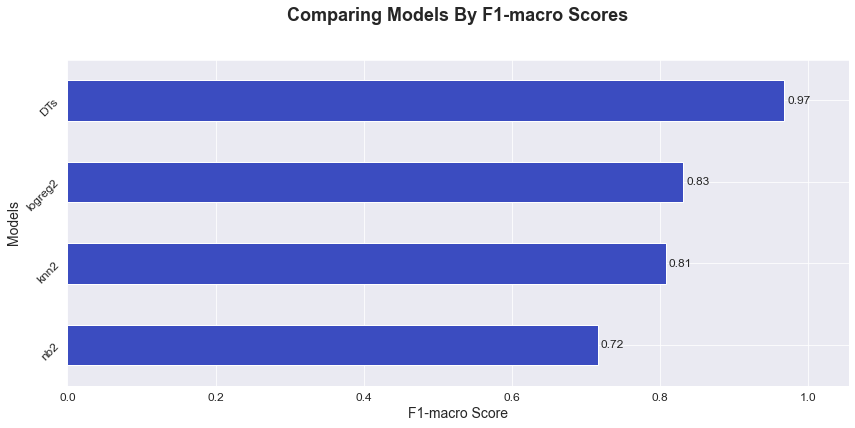

In [63]:
plt.figure(figsize = (14, 6))
ax = compare_clf2.loc["F1"].sort_values().plot(kind = "barh", colormap = plt.cm.coolwarm)
set_freq_label(ax)
plt.margins((0.09))
plt.xlabel("F1-macro Score")
plt.ylabel("Models")
plt.title("Comparing Models By F1-macro Scores", fontsize = 18, fontweight = "bold", y = 1.1)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

__Conculsion :__
   - __The reason why i used f1-macro scores is that this shows better and more trustable result than the others 
     in imbalanced data__
   - __More F1-macro score more Attention to the both clasess, that time we have a balanced model__
   - __Here, Decision Tree works much better than the others, so The Decison Tree model is selected as the final model__

__Decision Tree is selected as the Final Model__ <br>
__DTs model building :__

In [64]:
base_tree = make_pipeline(StandardScaler(), DecisionTreeClassifier())
base_tree.fit(X_train, y_train)
y_pred_test = base_tree.predict(X_test)
y_pred_train = base_tree.predict(X_train)
y_pred_proba = base_tree.predict_proba(X_test)

__Model evaluation :__

In [65]:
evaluate_model("Decision Tree", y_test, y_pred_test, y_train, y_pred_train)

*********************Decision Tree*********************
Test result :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1126
           1       0.96      0.92      0.94       124

    accuracy                           0.99      1250
   macro avg       0.97      0.96      0.97      1250
weighted avg       0.99      0.99      0.99      1250

Confusion matrix
[[1121    5]
 [  10  114]]
--------------------
Counter({0: 1131, 1: 119})
-------------------------------------------------------
Train result :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3393
           1       1.00      1.00      1.00       356

    accuracy                           1.00      3749
   macro avg       1.00      1.00      1.00      3749
weighted avg       1.00      1.00      1.00      3749

Confusion matrix
[[3393    0]
 [   0  356]]
--------------------
Counter({0: 3393, 1: 356})
---------------------

__Conculstion :__
   - __The Decision-Tree model is overfit, however it gets great results on test data <br>  and makes a balanced result for both class 0,1 that is what i wanted because<br>the dataset is imbalanced, So as a result of getting balanced scores i am <br>going to tune this model to get rid of overfitting__

### Step 7.3.2 : Plot Curves

#### Step 7.3.2.1 : PrecisionRecall Curve :

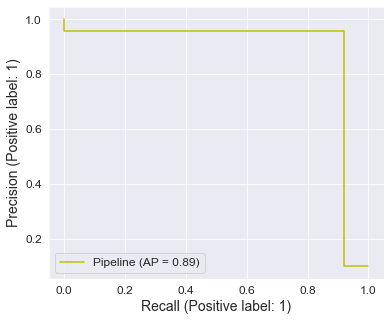

In [66]:
fig, ax = plt.subplots(figsize = (6, 5))
PrecisionRecallDisplay.from_estimator(base_tree, X_test, y_test, ax = ax, color = "y")
plt.grid()
plt.show()

#### Step 7.3.2.2 : Roc Curve :

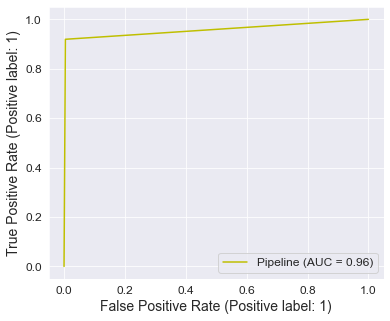

In [67]:
fig, ax = plt.subplots(figsize = (6, 5))
RocCurveDisplay.from_estimator(base_tree, X_test, y_test, ax = ax, color = "y")
plt.grid()
plt.show()

### Step 7.3.3 : Hyperparameter Tuning 

__Selected hyperparameters :__

In [68]:
params = {
    'decisiontreeclassifier__max_depth': [ 5, 10, 20, 25, 30],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100, 150],
    'decisiontreeclassifier__min_samples_split' : [5, 10, 20, 50, 100, 150],
    'decisiontreeclassifier__min_weight_fraction_leaf' : np.arange(0.01, 0.06, .01)
} 

__These range of numbers is not special, they have been obtained by trial and error <br>__
__Note : min_weight_fraction_leaf is the fraction of the input samples required to be <br> at a leaf node where weights are determined by sample_weight, this is a way to<br> deal with ( class imbalance )__

#### Step 7.3.3.1 : Hyperparameter Validation Curve

__The validation curve is a graphical technique that can be used to measure the influence of a single <br>hyperparameter By looking at this curve, you can determine if the model is underfitting, overfitting<br> or just-right for some range of hyperparameter values__


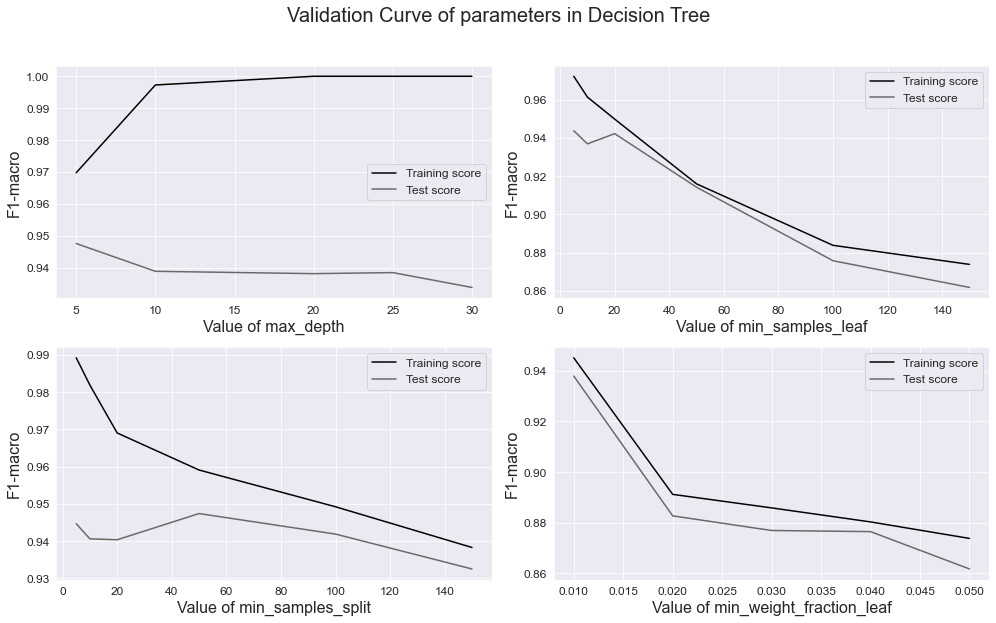

In [69]:
plt.figure(figsize = (14,8))
for idx, (param_name, param_range) in enumerate(params.items()):
    param_range = param_range
    train_scores, test_scores = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train, y = y_train, 
                                param_name = param_name.split("__")[1], 
                                param_range = param_range, cv = 5, scoring = "f1_macro")
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    ax = plt.subplot(2,2, idx + 1)
    ax.plot(param_range, train_mean, label="Training score", color="black")
    ax.plot(param_range, test_mean, label="Test score", color="dimgrey")

    ax.xaxis.set_label_text("Value of {}".format(param_name.split("__")[1]), size = 16)
    ax.yaxis.set_label_text("F1-macro",size = 16)
    ax.tick_params(labelsize = 12)
    ax.legend(loc="best")
    ax.grid()
plt.tight_layout()
plt.suptitle("Validation Curve of parameters in Decision Tree", size = 20, y = 1.08)
plt.show()

__Conculsion :__
  - __max-depth : best fit on 5 and the bigger ones causes overfitting__
  - __min_samples_leaf : best fit on almost 5 and the bigger ones causes underfitting__
  - __min_samples_split : best fit on almost 5 and the bigger ones causes underfitting__
  - __min_weight_fraction_leaf : best fit on 0.01 and the bigger ones causes underfitting__
  - __To be more confident, i will use hyperparameter tuning using GridSearchCV__ 
  

#### Step 7.3.3.2 : Tuning Hyperparameters On DTs Model 

In [70]:
dts = make_pipeline(StandardScaler(), DecisionTreeClassifier())
grid_dts = GridSearchCV(estimator=dts, 
                           param_grid=params, 
                           cv = StratifiedKFold(4, shuffle = True, random_state = 0),
                           n_jobs=-1, verbose = 1, scoring = "f1_macro")

__Using StratifiedKFold is because of its robustness on imbalanced data <br>
Stratified ensures that each fold of dataset has the same proportion of <br> observations with a given label__

__Fitting model :__

In [71]:
%%time
grid_dts.fit(X_train, y_train)

Fitting 4 folds for each of 900 candidates, totalling 3600 fits
CPU times: user 1.77 s, sys: 240 ms, total: 2.01 s
Wall time: 5.94 s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 10, 20, 25,
                                                               30],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50, 100,
                                                                      150],
                         'decisiontreeclassifier__min_samples_split': [5, 10,
                                                                       20, 50,
                                                                       100,
                                                                       150

__Best Parameters :__

In [72]:
grid_dts.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 5,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.01}

__Best F1-macro Score :__

In [73]:
print(grid_dts.best_score_)

0.941030324464778


### Step 7.3.4 : Final Model With The Best Parameters

__Final model building :__

In [74]:
final_model_tree = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=5,
                                        min_weight_fraction_leaf=0.01))
final_model_tree.fit(X_train, y_train)
y_pred_test = final_model_tree.predict(X_test)
y_pred_train = final_model_tree.predict(X_train)
y_pred_proba_tree = final_model_tree.predict_proba(X_test)

__Model evaluation :__

In [75]:
evaluate_model("Decision Tree", y_test, y_pred_test, y_train, y_pred_train)

*********************Decision Tree*********************
Test result :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1126
           1       0.95      0.86      0.90       124

    accuracy                           0.98      1250
   macro avg       0.97      0.93      0.95      1250
weighted avg       0.98      0.98      0.98      1250

Confusion matrix
[[1120    6]
 [  17  107]]
--------------------
Counter({0: 1137, 1: 113})
-------------------------------------------------------
Train result :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3393
           1       0.92      0.89      0.90       356

    accuracy                           0.98      3749
   macro avg       0.95      0.94      0.95      3749
weighted avg       0.98      0.98      0.98      3749

Confusion matrix
[[3365   28]
 [  40  316]]
--------------------
Counter({0: 3405, 1: 344})
---------------------

__Conculsion :__
 - __Comparing to the previous Decision Tree report, here we have almost much more balanced scores on the both clasess__ 
 - __Now, we can trust the accuracy score which is 98% on the test result as well as train result, it is great__
 - __There is no overfitting or underfitting state, the model is just-right__

#### Step 7.3.4.1 : Tree Plot

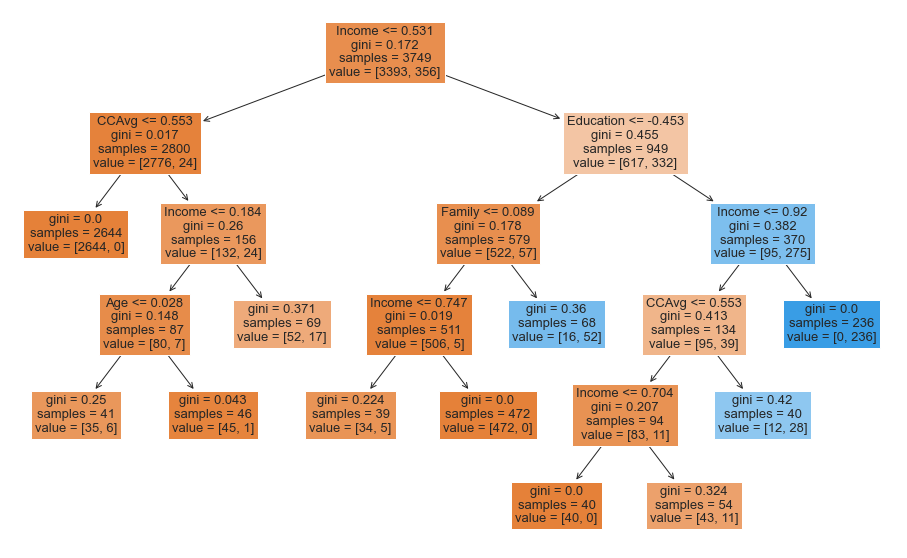

In [76]:
plt.figure(figsize = (16,10))
plot_tree(final_model_tree[1],feature_names = X.columns, fontsize = 13, filled = True, )
plt.show()

#### Step 7.3.4.2: Feature Importance

__Selecting feature importances :__

In [77]:
feature_importance = pd.Series(final_model_tree[1].feature_importances_, index = final_model_tree.feature_names_in_)

__Plotting feature importances :__

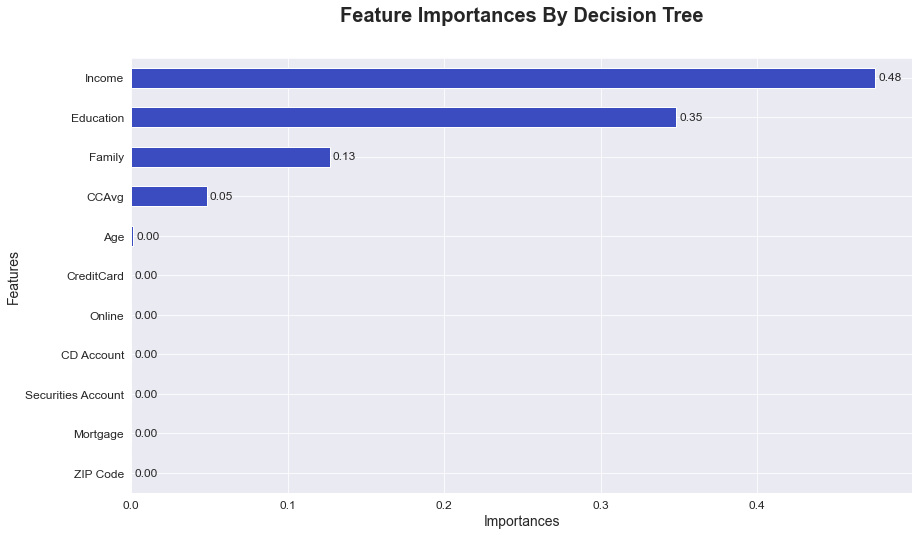

In [78]:
plt.figure(figsize = (14,8))
ax = feature_importance.sort_values().plot.barh(cmap = plt.cm.coolwarm)
plt.title("Feature Importances By Decision Tree", size = 20, y = 1.07, fontweight = "bold")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.grid()
set_freq_label(ax)

__Conculsion :__
   + __The final Decision Tree model just uses the features named ( Income, Education, Family, CCAvg ), <br>
    the Other features are unusable from Age to ZIP Code__
   + __The order of importance : Income > Education > Family > CCAvg__


#### Step 7.3.4.3 : Confusion matrix

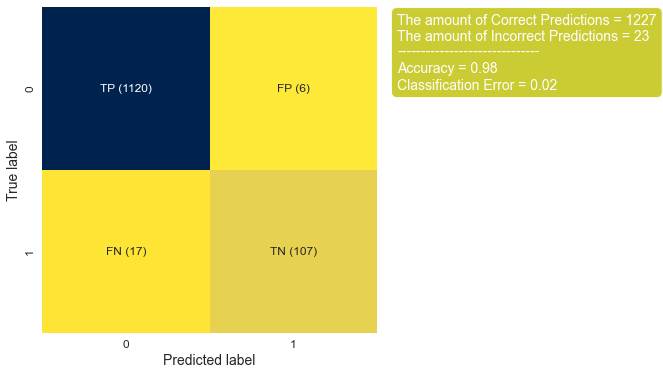

In [79]:
plot_confusion_matrix_legend(y_test, y_pred_test)

#### Step 7.3.4.4 : PrecisionRecall Curve

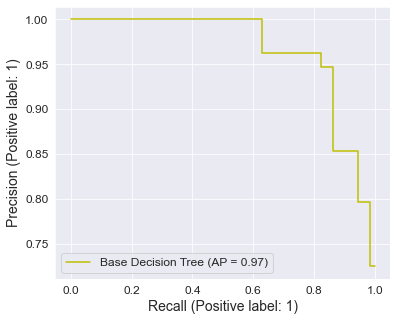

In [80]:
fig, ax = plt.subplots(figsize = (6, 5))
PrecisionRecallDisplay.from_estimator(final_model_tree, X_test, y_test, name='Base Decision Tree', ax = ax, color = "y")
plt.grid()

__It increased by 10% compared to the previous one__

#### Step 7.3.4.5 : Roc Curve

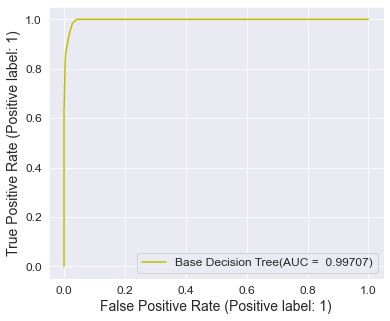

In [81]:
fig, ax = plt.subplots(figsize = (6, 5))
RocCurveDisplay.from_estimator(final_model_tree, X_test, y_test, name= "Base Decision Tree", ax = ax, 
                               label = 
                               f"Base Decision Tree(AUC = {roc_auc_score(y_test, y_pred_proba_tree[:, 1]): .5f})",
                              color = "y")
plt.grid()

------
# 🏆 Accuracy: 98 %

## Best Regards!